In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU,Dropout
import librosa

In [2]:
def df_to_vector_array(df,
                       sampling_rate = 48000,
                       hop_length = 2048,
                       n_fft = 65536):
    ample_array = np.array(df.loc[:,'ample'])
    n_fft = n_fft

    # フレームごとのシフトサイズ（一般的には `n_fft // 4` など）
    hop_length = hop_length

    # メルスペクトログラムの生成
    mel_spectrogram = librosa.feature.melspectrogram(y=ample_array, sr=sampling_rate, n_fft=n_fft, hop_length=hop_length)

    # MFCC の計算 (13係数で設定)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(mel_spectrogram), n_mfcc=13)

    return mfccs

In [3]:
sampling_rate = 48000
df = pd.read_csv('../data/20240509/raw/mic_normal1.csv')
mfccs = df_to_vector_array(df, sampling_rate = sampling_rate)

In [4]:
training_data = []
x_train = []
y_train = []
data_frames = []

for i in range(8):
    if( i == 3 or  i == 7):
        continue
    path_to_mfcc_coord = f'../data/20240509/processed/mfcc_coordinate{i}.csv'
    df = pd.read_csv(path_to_mfcc_coord)
    data_frames.append(df)
    
combined_df = pd.concat(data_frames, ignore_index=True)

y_columns_to_use = [f'mfcc_{i}' for i in range(13)]

y_train = combined_df[y_columns_to_use].values


In [5]:
data_frames_abnormal = []
for i in range(2):
    path_to_mfcc_coord = f'../data/20240509/processed/abnormal_mfcc_coordinate{i}.csv'
    df = pd.read_csv(path_to_mfcc_coord)
    data_frames_abnormal.append(df)
    
combined_df_abnormal = pd.concat(data_frames_abnormal, ignore_index=True)

In [6]:
data_frames_normal = []

for i in range(2):
    path_to_mfcc_coord = f'../data/20240509/processed/normal_mfcc_coordinate{i*4+3}.csv'
    df = pd.read_csv(path_to_mfcc_coord)
    data_frames_normal.append(df)
    
combined_df_normal = pd.concat(data_frames_normal, ignore_index=True)

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense

# グリッドの数を設定する（x軸、y軸方向）
num_x_grids = 2  # 必要に応じて調整してください
num_y_grids = 2

# データセットに基づいてグリッド境界を設定する
x_min, x_max = combined_df['x'].min(), combined_df['x'].max()
y_min, y_max = combined_df['y'].min(), combined_df['y'].max()
x_grid_size = (x_max - x_min) / num_x_grids
y_grid_size = (y_max - y_min) / num_y_grids

# 各座標を対応するグリッドに割り当てる
def assign_grid(x, y):
    x_grid = int((x - x_min) // x_grid_size)
    y_grid = int((y - y_min) // y_grid_size)
    return x_grid, y_grid

combined_df['grid'] = combined_df.apply(lambda row: assign_grid(row['x'], row['y']), axis=1)

# 正規化関数の定義
std_weight = 3
def min_max_scaler(arr, min_val, max_val):
    arr = (arr - min_val) / (max_val - min_val)
    arr = np.where(arr < 0, 0, arr)
    arr = np.where(arr > 1, 1, arr)
    return arr


# オートエンコーダーのモデル作成・トレーニング用の関数
def create_and_train_autoencoder(X, encoding_dim=8, epochs=20):
    input_dim = X.shape[1]
    
    # モデルの定義
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    
    # モデルのコンパイル
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    # 学習
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
    autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=32, shuffle=True, validation_data=(X_test, X_test))
    
    return autoencoder

# 各グリッドでモデルを作成し、学習
autoencoder_models = {}
for x_grid in range(num_x_grids):
    for y_grid in range(num_y_grids):
        grid_data = combined_df[combined_df['grid'] == (x_grid, y_grid)]
        if len(grid_data) > 0:
            X_train_grid = grid_data[y_columns_to_use].values
            
            # 各グリッドのデータを正規化
            for idx in range(X_train_grid.shape[1]):
                mean_val = y_train[:, idx].mean()
                std_val = y_train[:, idx].std()
                max_val = mean_val + std_weight * std_val
                min_val = mean_val - std_weight * std_val
                X_train_grid[:, idx] = min_max_scaler(X_train_grid[:, idx], min_val, max_val)
            
            model_key = f"grid_{x_grid}_{y_grid}"
            autoencoder_models[model_key] = create_and_train_autoencoder(X_train_grid, encoding_dim=8, epochs=20)

# 各グリッドのオートエンコーダーモデルはautoencoder_models辞書に保存されます


Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0240 - val_loss: 0.0206
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195 - val_loss: 0.0193
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0191 - val_loss: 0.0182
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187 - val_loss: 0.0173
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - val_loss: 0.0166
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0161 - val_loss: 0.0160
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159 - val_loss: 0.0154
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - val_loss: 0.0149
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153 - val_loss: 0.0144
Epoch 10/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143 - val_loss: 0.0140
Epoch 11/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137 - val_loss: 0.0136
Epoch 12/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132 - val_lo

In [8]:
combined_df

,Unnamed: 0.1,time,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,Unnamed: 0,x,y,z,grid
0,0,0.170667,72.134429,22.165651,-68.261936,50.390870,-16.427406,24.646663,-14.715203,14.076378,-7.934714,2.793114,-9.095302,2.704014,-9.348587,0,0.916439,-1.829320,0.105969,"(1, 0)"
1,1,0.213333,79.562946,22.506460,-68.440287,50.749996,-16.666536,24.737653,-15.078240,14.199040,-8.175452,2.941544,-9.369044,3.051581,-9.614959,0,0.916439,-1.829320,0.105969,"(1, 0)"
2,2,0.256000,85.800752,22.765162,-68.523210,51.041740,-16.793550,24.758218,-15.357365,14.241954,-8.354118,3.005345,-9.544899,3.323539,-9.809007,0,0.916439,-1.829320,0.105969,"(1, 0)"
3,3,0.298667,90.939271,22.979189,-68.556331,51.308512,-16.849326,24.746697,-15.592469,14.241551,-8.511037,3.020945,-9.656687,3.552302,-9.960585,0,0.916439,-1.829320,0.105969,"(1, 0)"
4,4,0.341333,95.075334,23.166927,-68.567748,51.574672,-16.858598,24.724972,-15.806658,14.218482,-8.670250,3.009385,-9.724748,3.757912,-10.085584,0,0.916439,-1.829320,0.105969,"(1, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7364,1046,44.800000,173.885346,79.134674,-35.178497,91.015382,-17.223014,33.218364,-8.352933,12.494830,-1.009033,9.438027,-9.558392,9.839160,-8.616158,1265,-1.217974,1.250939,0.080898,"(0, 1)"
7365,1047,44.842667,171.516662,79.830692,-34.476912,91.557446,-17.010211,33.166462,-8.334749,12.190841,-1.016869,9.323244,-9.699231,9.791014,-8.488278,1266,-1.207595,1.233357,0.096940,"(0, 1)"
7366,1048,44.885333,168.102543,80.346994,-33.872176,91.995403,-16.835936,33.050181,-8.312253,11.880831,-0.962070,9.196725,-9.823509,9.728472,-8.318886,1268,-1.233521,1.261910,0.070193,"(0, 1)"
7367,1049,44.928000,163.539555,80.700701,-33.348993,92.332461,-16.690443,32.874628,-8.277554,11.566141,-0.841715,9.052901,-9.927543,9.646220,-8.106925,1269,-1.245943,1.268829,0.071932,"(0, 1)"


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


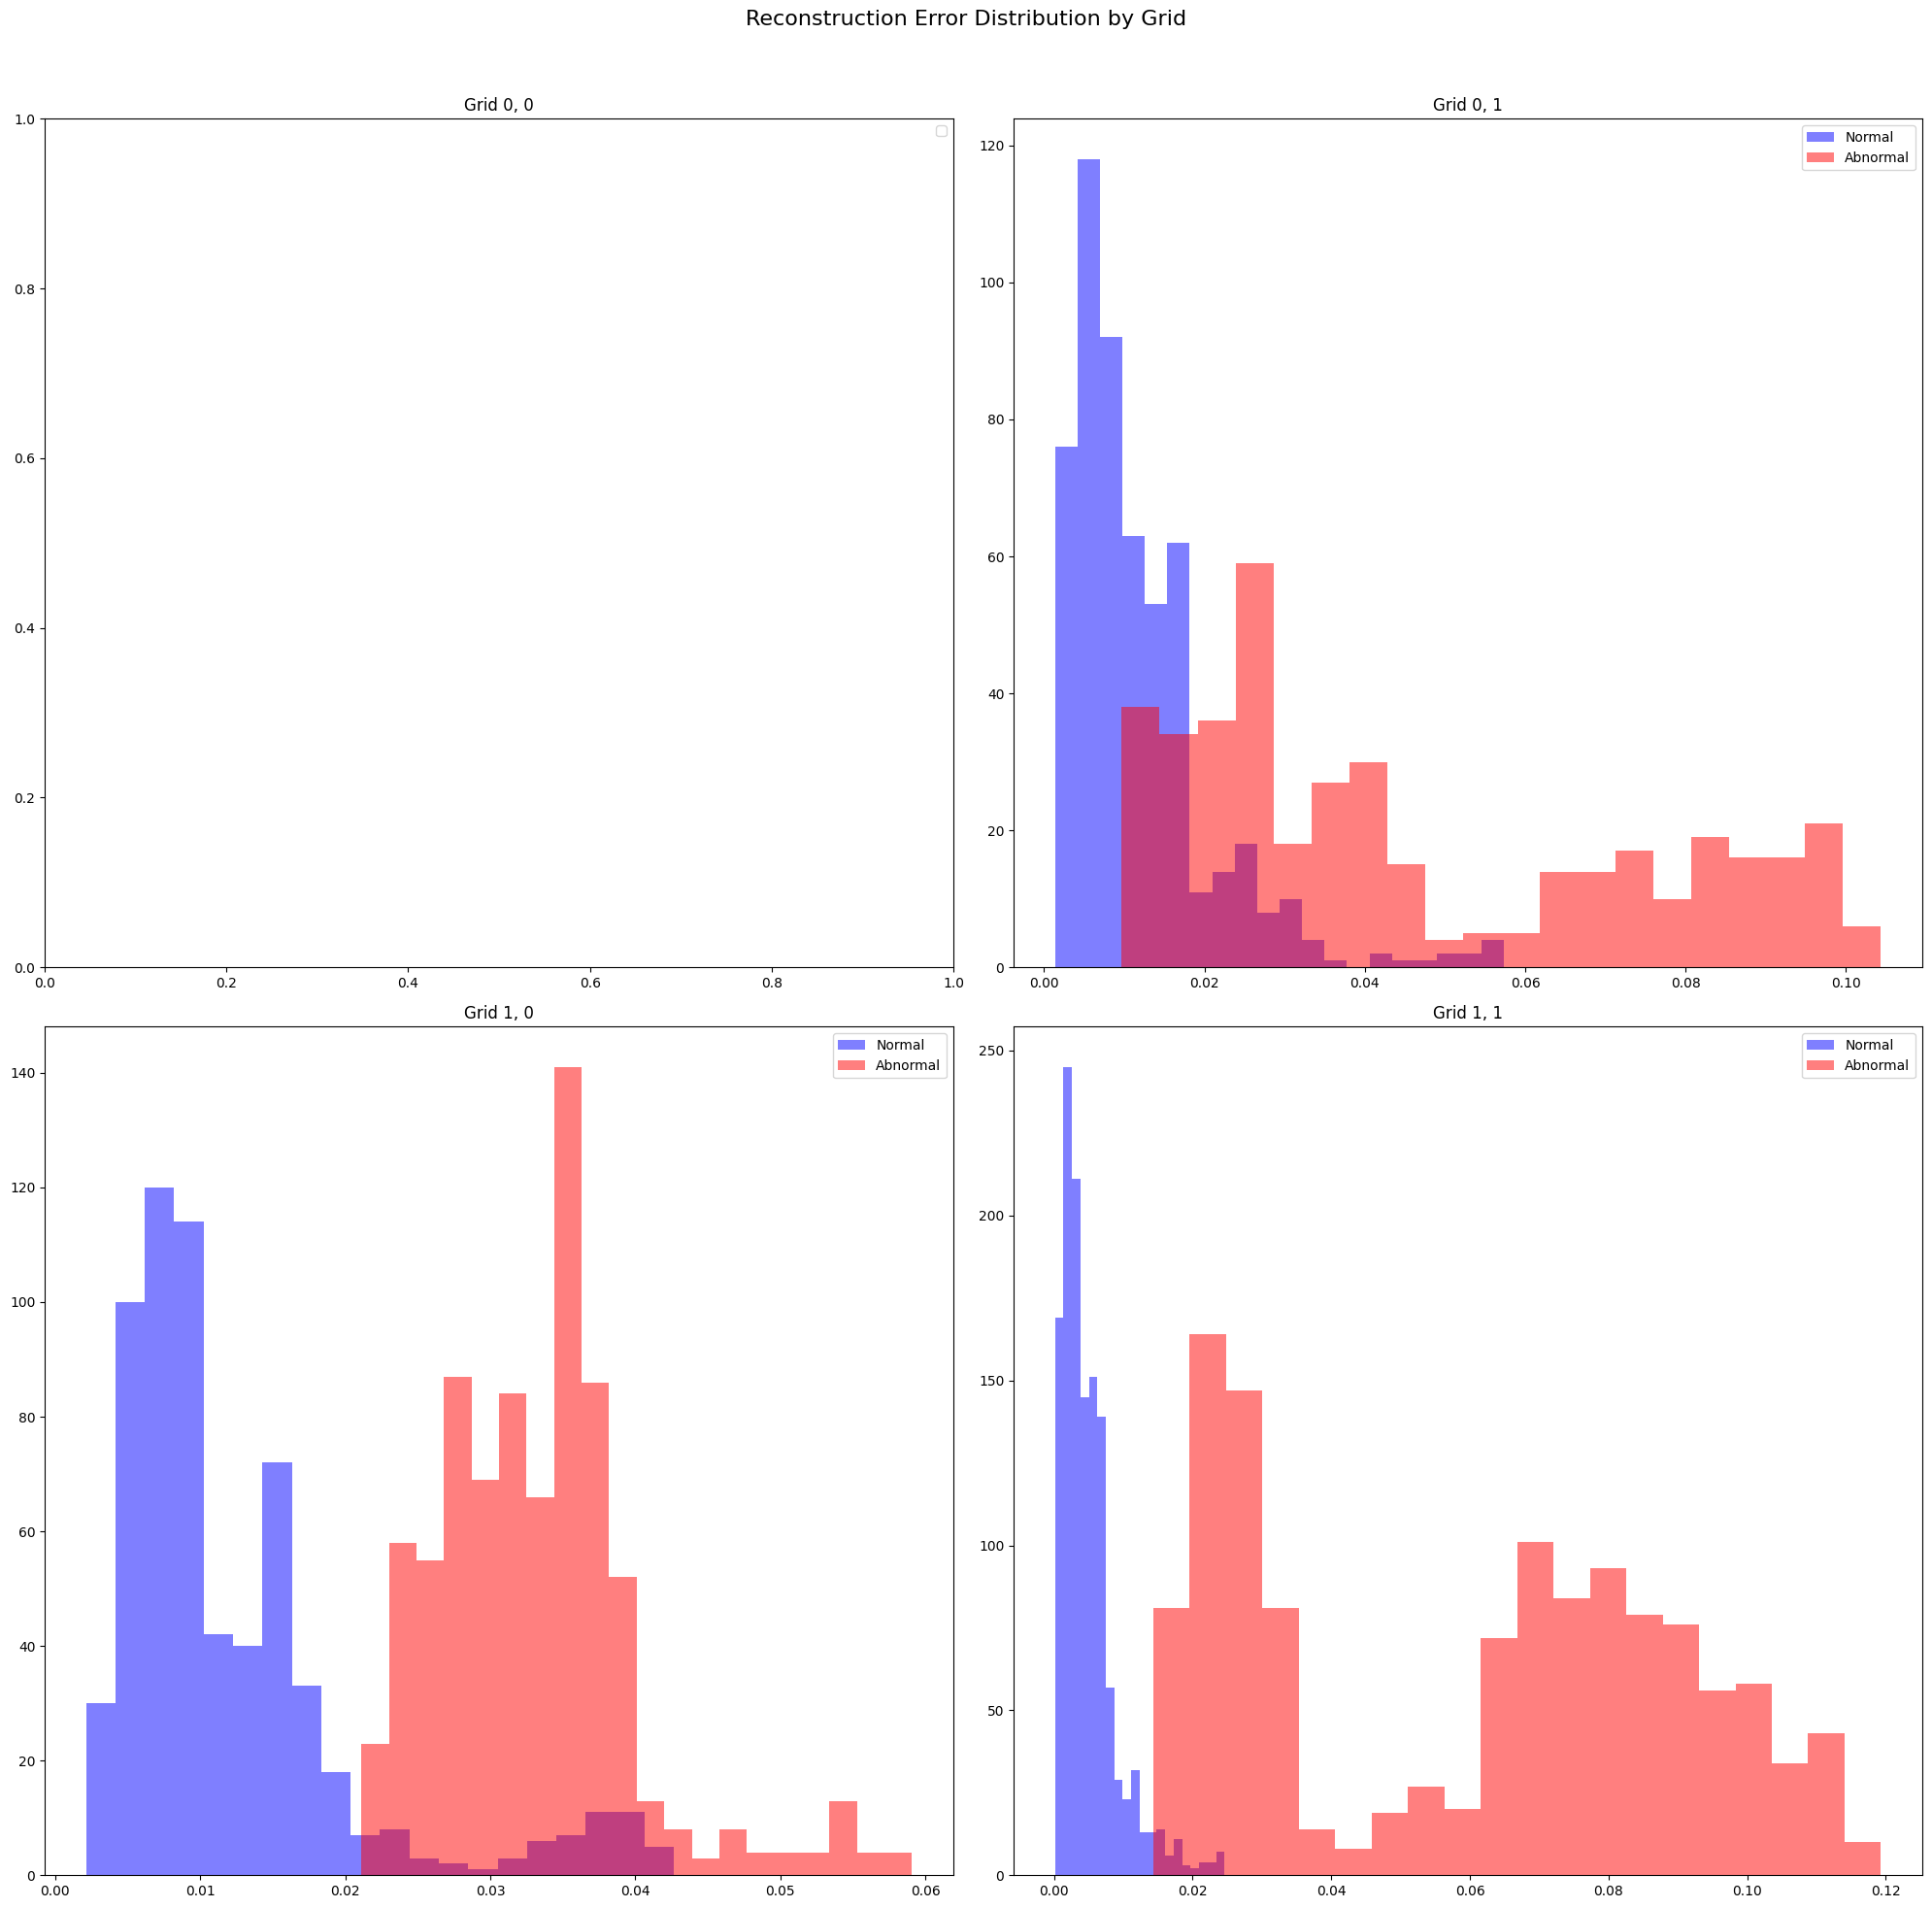

In [9]:
import matplotlib.pyplot as plt

# 各データフレームにおけるグリッドを特定し、予測を取得する関数
def predict_grid_data(df, models, y_columns_to_use, num_x_grids, num_y_grids, x_min, x_max, y_min, y_max):
    x_grid_size = (x_max - x_min) / num_x_grids
    y_grid_size = (y_max - y_min) / num_y_grids

    # グリッド割り当て関数
    def assign_grid(x, y):
        x_grid = int((x - x_min) // x_grid_size)
        y_grid = int((y - y_min) // y_grid_size)
        return x_grid, y_grid

    # グリッド割り当て列を作成
    df['grid'] = df.apply(lambda row: assign_grid(row['x'], row['y']), axis=1)

    # グリッドごとに予測結果を取得
    results = {}
    for x_grid in range(num_x_grids):
        for y_grid in range(num_y_grids):
            grid_data = df[df['grid'] == (x_grid, y_grid)]
            if len(grid_data) > 0:
                model_key = f"grid_{x_grid}_{y_grid}"
                if model_key in models:
                    model = models[model_key]
                    X_grid = grid_data[y_columns_to_use].values
                    # 予測出力を得る
                    predictions = model.predict(X_grid)
                    reconstruction_error = np.mean((X_grid - predictions) ** 2, axis=1)
                    results[model_key] = reconstruction_error

    return results

def min_max_scaler(arr,min_val,max_val):
    arr = (arr-min_val)/(max_val-min_val)   
    arr = np.where(arr < 0, 0, arr)
    arr = np.where(arr > 1, 1, arr)
    return arr

# 正規化関数の定義（テストデータにも同じ正規化を適用する）
def normalize_test_data(df, y_columns_to_use, std_weight):
    for idx, column in enumerate(y_columns_to_use):
        mean_val = y_train[:, idx].mean()
        std_val = y_train[:, idx].std()
        max_val = mean_val + std_weight * std_val
        min_val = mean_val - std_weight * std_val
        df[column] = min_max_scaler(df[column].values, min_val, max_val)

# テストデータの正規化
normalize_test_data(combined_df_normal, y_columns_to_use, std_weight)
normalize_test_data(combined_df_abnormal, y_columns_to_use, std_weight)

# 予測とエラーデータを得る
normal_results = predict_grid_data(combined_df_normal, autoencoder_models, y_columns_to_use, num_x_grids, num_y_grids, x_min, x_max, y_min, y_max)
abnormal_results = predict_grid_data(combined_df_abnormal, autoencoder_models, y_columns_to_use, num_x_grids, num_y_grids, x_min, x_max, y_min, y_max)

# 各グリッドごとの分布をプロット
fig, axes = plt.subplots(num_x_grids, num_y_grids, figsize=(20, 20))
fig.suptitle("Reconstruction Error Distribution by Grid", fontsize=16)

for x_grid in range(num_x_grids):
    for y_grid in range(num_y_grids):
        model_key = f"grid_{x_grid}_{y_grid}"
        ax = axes[x_grid, y_grid]
        
        if model_key in normal_results:
            ax.hist(normal_results[model_key], bins=20, alpha=0.5, label='Normal', color='blue')
        
        if model_key in abnormal_results:
            ax.hist(abnormal_results[model_key], bins=20, alpha=0.5, label='Abnormal', color='red')
        
        ax.set_title(f"Grid {x_grid}, {y_grid}")
        ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [10]:
mses = np.array([])
labels = np.array([])

for label, results in enumerate([normal_results, abnormal_results]):
    for value in results.values():
        mses = np.concatenate([mses, value], axis=0)
        labels = np.concatenate([labels, np.array([label]*len(value))], axis=0)

AUC: 0.9759


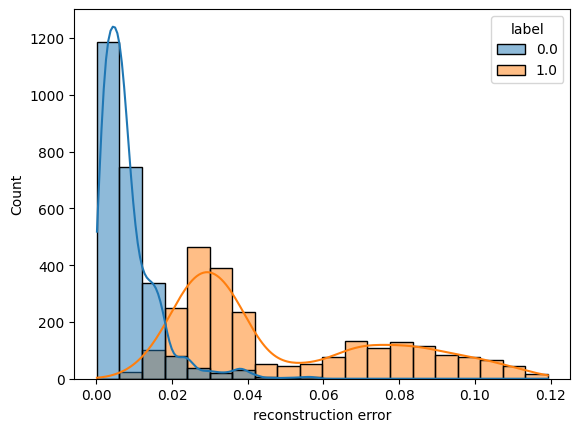

In [11]:
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler


plt_df = pd.DataFrame({'reconstruction error': mses, 'label': labels})
sns.histplot(data=plt_df, x='reconstruction error', hue='label', bins=20, kde=True)

# Min-Maxスケーリング
scaler = MinMaxScaler()
y_scores_scaled = scaler.fit_transform(np.array(plt_df['reconstruction error']).reshape(-1, 1)).flatten()

# AUC計算
auc = roc_auc_score(plt_df['label'], y_scores_scaled)
# 結果の出力
print(f"AUC: {auc:.4f}")

In [12]:
#lightgbmによる学習(ハイパラはデフォルト)

In [13]:
mses

array([0.02278114, 0.02462844, 0.02637228, ..., 0.0920746 , 0.09129491,
       0.08948101])